# Digit Recognizer (CNN)

Import the required dependencies

In [1]:
import pandas as pd  #Pandas for working with dataframes.
import numpy as np  #Numpy for working with matrices and linear algebra.
import tensorflow as tf #Tensorflow for model generation.
from keras.preprocessing.image import ImageDataGenerator #Keras For data generation ie to make our data large.
from sklearn.model_selection import train_test_split #Scikit learn for train- test splitting our data
import matplotlib.pyplot as plt #Matplotlib for plotting graphs or images.

### Loading the data

We begin by loading the data into the variable "path" and then map it to a variable "mnist_training".

In [2]:
path = "/kaggle/input/digit-recognizer/train.csv"
mnist_training = pd.read_csv(path)

### Inspecting the data

Next, we inspect the structure of the dataset. How many samples do we have? How is the data labeled and what structure does it have?

In [3]:
mnist_training.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What kind of values can be observed within the pixel-columns?

In [4]:
mnist_training.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The pixel values range from 0 to 255. We can rescale this to the interval [0,1]. We will do this in a few moments. The first column is the label of the handwritten digit we aim to identify. There are 784 columns following the label, each one respresenting one of the 784 pixels. The pictures are of size 28x28, giving us 784 columns. Looking at the "count" of each column, we see that we have a total of 42 000 training samples. Next we can look at the possible label values.

In [5]:
mnist_training['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

As can be seen, each digit from 0 to 9 is represented in our dataset. Are they evenly distributed or is our dataset unbalanced?

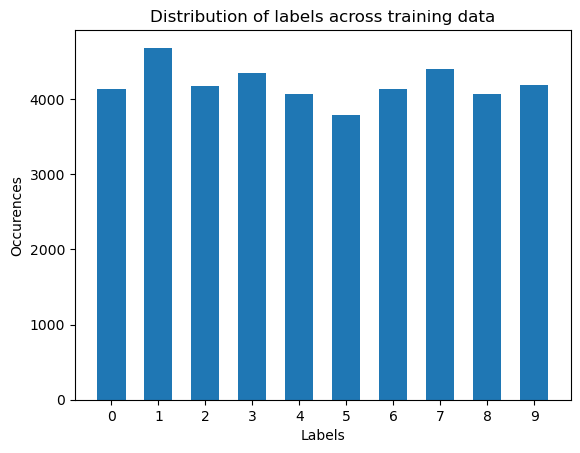

In [6]:
plt.hist(mnist_training['label'], bins=range(11), rwidth=0.6, align='left')
plt.xticks(range(10))
plt.title("Distribution of labels across training data")
plt.ylabel('Occurences')
plt.xlabel('Labels')
plt.show()

The data look balanced! We can also do a visual inspection of our explanatory data, to better understand it and how we will solve the problem. Let us plot the first 25 instances.

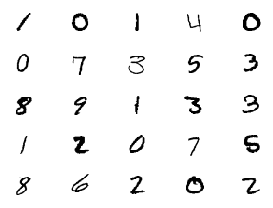

In [7]:
plt.figure(figsize=(3,3)) #Setting the size for the figure
for digit_num in range(25): #Getting  the first 25 images
    plt.subplot(7,5,digit_num+1)
    grid_data = mnist_training.iloc[digit_num,1:].to_numpy().reshape(28,28)
    plt.imshow(grid_data, interpolation = "none", cmap = plt.cm.binary)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Data Preperation

Before we start building the model, we can split the data into training and validation data. This will help us prevent overfitting of our neural network.

In [8]:
#Setting X to pictures and y to labels
X = mnist_training.iloc[:,1:]
y = mnist_training.iloc[:,0]

#Let us reshape the data to 28x28
X = X.values.reshape(-1, 28, 28, 1)

#Let us rescale the values from 0-255 to 0-1
X = X/255.0

#Splitting the training data into traizning and validation data.
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size = 0.2, random_state = 10)

We can increase our dataset a lot by applying various permuations to our images. We use ImageDataGenerator for this

In [9]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range 20 degrees
        zoom_range = 0.2, # Randomly zoom image 20%
        width_shift_range=0.2,  # randomly shift images horizontally 20%
        height_shift_range=0.2,  # randomly shift images vertically 20%
        shear_range=0.2) #shear intensity 20%


datagen.fit(X_train)

### Definig a callback

We are content with an accuracy of 0.999 on the validation set, which will give a solid rank at the leaderboard. Hitting this level of accuracy during training it will stop, potentially saving us for some time and decrease the risk of overfitting.

In [10]:
#Define an accuracy callback
class myAccuracyCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.999:
                print("\nReached 99.9% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

### Building a Neural Network

We now begin building our model. We use three convolutional layers, with an increasing amount of filters. In between, we employ max pooling layers to reduce the number of parameters. The second part of the network consists of three dense layer. Finally we have an output to a dense layer of 10 units, one for each digit. Using the softmax activation function, we ensure that the output to each unit sum to 1.

In [11]:
#Initialize hyperparameters
EPOCHS = 50
BATCH_SIZE = 250

# Instantiate the callback class
accuracyCallbacks = myAccuracyCallback()

# Define the model
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPooling2D(2), #Maxpooling to reduce the parameters
    
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2), #Maxpooling to reduce the parameters
    
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2), #Maxpooling to reduce the parameters
    
    tf.keras.layers.Flatten(),
    
    #Dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dropout(rate=0.3),
    #output layer
    tf.keras.layers.Dense(10, activation='softmax')
])

In [12]:
# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [13]:
# Fit the model adding the callback and save the training history
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    validation_data=(X_validation, y_validation), 
                    steps_per_epoch=len(X_train)/BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[accuracyCallbacks])

Epoch 1/50
134/134 [==============================] - 23s 88ms/step - loss: 1.1527 - accuracy: 0.5942 - val_loss: 0.1514 - val_accuracy: 0.9538
Epoch 2/50
134/134 [==============================] - 12s 86ms/step - loss: 0.2734 - accuracy: 0.9196 - val_loss: 0.0653 - val_accuracy: 0.9795
Epoch 3/50
134/134 [==============================] - 11s 81ms/step - loss: 0.1817 - accuracy: 0.9467 - val_loss: 0.0647 - val_accuracy: 0.9795
Epoch 4/50
134/134 [==============================] - 11s 85ms/step - loss: 0.1305 - accuracy: 0.9621 - val_loss: 0.0425 - val_accuracy: 0.9865
Epoch 5/50
134/134 [==============================] - 12s 86ms/step - loss: 0.1148 - accuracy: 0.9673 - val_loss: 0.0477 - val_accuracy: 0.9855
Epoch 6/50
134/134 [==============================] - 11s 85ms/step - loss: 0.1011 - accuracy: 0.9712 - val_loss: 0.0337 - val_accuracy: 0.9883
Epoch 7/50
134/134 [==============================] - 11s 85ms/step - loss: 0.0943 - accuracy: 0.9740 - val_loss: 0.0358 - val_accuracy:

### Inspecting our results

Let us produce some plots and investigate how it went.

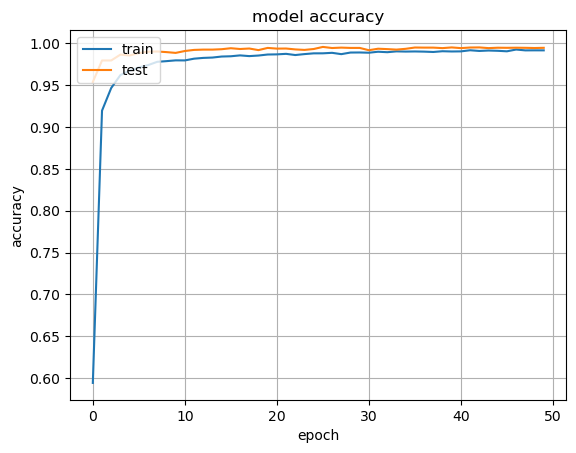

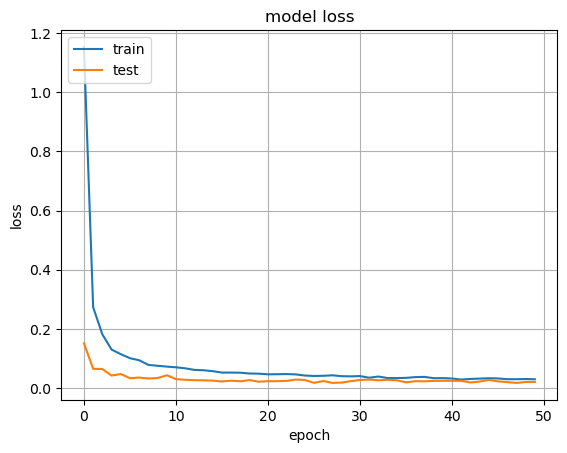

In [14]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [15]:
path_test = "/kaggle/input/digit-recognizer/test.csv"
mnist_test = pd.read_csv(path_test)
X_test = mnist_test.to_numpy()
X_test = X_test/.255 
X_test = np.array(X_test).reshape(X_test.shape[0], 28, 28, 1)

In [16]:
y_pred = model.predict(X_test)
preds_test = np.argmax(y_pred,axis = 1)

sample_sub = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
test_id = sample_sub.ImageId.copy()

results = pd.Series(preds_test,name="Label")
output = pd.DataFrame({'ImageId': test_id,
                       'Label': preds_test})

output.to_csv('submission.csv', index=False)

875/875 [==============================] - 2s 2ms/step
